In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
clean_data_filename = '/content/drive/MyDrive/lab4/cl/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/lab4/bd/bd_valid.h5'
model_filename = '/content/drive/MyDrive/lab4/model/sunglasses_bd_net.h5'

In [5]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)

    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()


361/361 [==============================] - 4s 10ms/step
Clean Classification accuracy: 42.25339915129471
361/361 [==============================] - 4s 10ms/step
Attack Success Rate: 99.9047371611674


In [6]:
model = keras.models.load_model(model_filename)


In [7]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [8]:
x_data, y_data = data_loader(clean_data_filename)


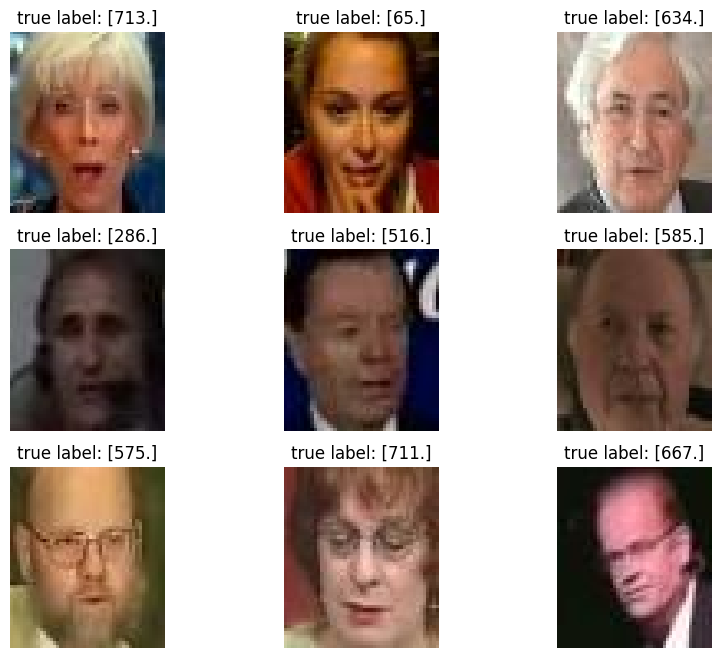

In [9]:

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [10]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)


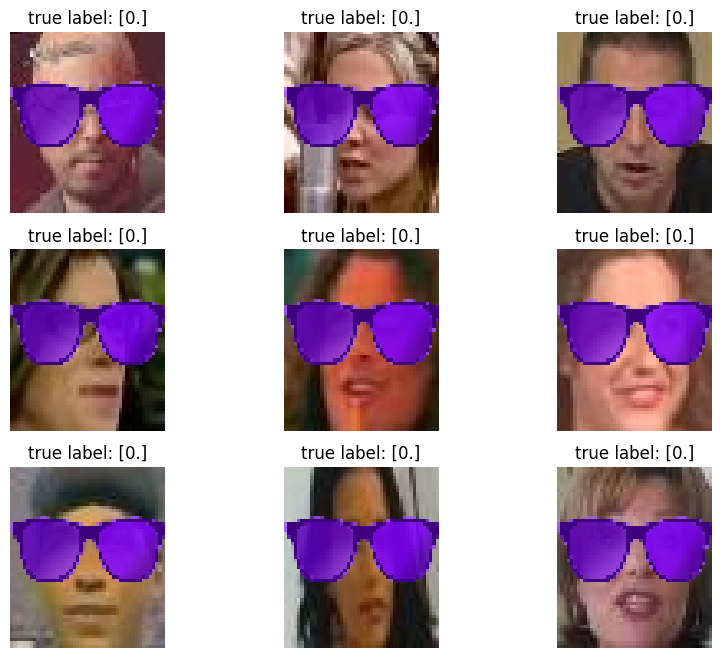

In [11]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [12]:
keras.backend.clear_session()

In [13]:
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [14]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()

361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The accuracy drops at least 2%, saved the model
The accuracy drops at least 4%, saved the model


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:09<09:06,  9.26s/it]


The clean accuracy is:  42.25339915129471
The attack success rate is:  99.9047371611674
The pruned channel index is:  32
361/361 [==============================] - 4s 10ms/step


  3%|▎         | 2/60 [00:18<08:57,  9.27s/it]


The clean accuracy is:  42.25339915129471
The attack success rate is:  99.9047371611674
The pruned channel index is:  44
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  42.25339915129471
The attack success rate is:  99.9047371611674
The pruned channel index is:  49


  5%|▌         | 3/60 [00:29<09:27,  9.96s/it]

361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  42.2620594093704
The attack success rate is:  99.9047371611674
The pruned channel index is:  37


  7%|▋         | 4/60 [00:38<09:02,  9.69s/it]

361/361 [==============================] - 4s 12ms/step


  8%|▊         | 5/60 [00:49<09:26, 10.29s/it]


The clean accuracy is:  42.2620594093704
The attack success rate is:  99.9047371611674
The pruned channel index is:  36
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  42.2620594093704
The attack success rate is:  99.9047371611674
The pruned channel index is:  31


 10%|█         | 6/60 [00:59<08:59,  9.99s/it]

361/361 [==============================] - 4s 10ms/step


 12%|█▏        | 7/60 [01:08<08:37,  9.76s/it]


The clean accuracy is:  42.25339915129471
The attack success rate is:  99.9047371611674
The pruned channel index is:  50
361/361 [==============================] - 4s 10ms/step


 13%|█▎        | 8/60 [01:18<08:20,  9.63s/it]


The clean accuracy is:  42.24473889321902
The attack success rate is:  99.9047371611674
The pruned channel index is:  48
361/361 [==============================] - 4s 11ms/step


 15%|█▌        | 9/60 [01:28<08:29, 10.00s/it]


The clean accuracy is:  42.227418377067636
The attack success rate is:  99.9047371611674
The pruned channel index is:  33
361/361 [==============================] - 4s 10ms/step


 17%|█▋        | 10/60 [01:38<08:08,  9.77s/it]


The clean accuracy is:  42.184117086689184
The attack success rate is:  99.9047371611674
The pruned channel index is:  14
361/361 [==============================] - 4s 10ms/step


 18%|█▊        | 11/60 [01:47<07:53,  9.66s/it]


The clean accuracy is:  42.07153373170521
The attack success rate is:  99.9047371611674
The pruned channel index is:  35
361/361 [==============================] - 4s 10ms/step


 20%|██        | 12/60 [01:56<07:37,  9.52s/it]


The clean accuracy is:  42.097514505932274
The attack success rate is:  99.9047371611674
The pruned channel index is:  34
361/361 [==============================] - 4s 10ms/step


 22%|██▏       | 13/60 [02:05<07:23,  9.44s/it]


The clean accuracy is:  41.88100805404001
The attack success rate is:  99.9047371611674
The pruned channel index is:  1
361/361 [==============================] - 4s 10ms/step


 23%|██▎       | 14/60 [02:15<07:12,  9.39s/it]


The clean accuracy is:  41.65584134407205
The attack success rate is:  99.9047371611674
The pruned channel index is:  2
361/361 [==============================] - 4s 10ms/step


 25%|██▌       | 15/60 [02:24<06:58,  9.30s/it]


The clean accuracy is:  41.48263618255824
The attack success rate is:  99.9047371611674
The pruned channel index is:  42
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  41.44799515025548
The attack success rate is:  99.9047371611674
The pruned channel index is:  12


 27%|██▋       | 16/60 [02:33<06:50,  9.34s/it]

361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  41.188187407984756
The attack success rate is:  99.89607690309171
The pruned channel index is:  24


 28%|██▊       | 17/60 [02:43<06:44,  9.42s/it]

361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [02:53<06:49,  9.74s/it]


The clean accuracy is:  40.61661037498918
The attack success rate is:  99.88741664501603
The pruned channel index is:  47
361/361 [==============================] - 4s 10ms/step


 32%|███▏      | 19/60 [03:03<06:36,  9.66s/it]


The clean accuracy is:  39.36953321208972
The attack success rate is:  99.89607690309171
The pruned channel index is:  3
361/361 [==============================] - 4s 11ms/step


 33%|███▎      | 20/60 [03:13<06:37,  9.93s/it]


The clean accuracy is:  38.62475101758032
The attack success rate is:  99.89607690309171
The pruned channel index is:  29
361/361 [==============================] - 4s 10ms/step


 35%|███▌      | 21/60 [03:23<06:18,  9.70s/it]


The clean accuracy is:  38.1830778557201
The attack success rate is:  99.88741664501603
The pruned channel index is:  58
361/361 [==============================] - 4s 10ms/step


 37%|███▋      | 22/60 [03:32<06:07,  9.66s/it]


The clean accuracy is:  37.550879016194685
The attack success rate is:  99.87875638694032
The pruned channel index is:  0
361/361 [==============================] - 4s 11ms/step


 38%|███▊      | 23/60 [03:42<05:55,  9.60s/it]


The clean accuracy is:  36.944660950896335
The attack success rate is:  99.89607690309171
The pruned channel index is:  8
361/361 [==============================] - 4s 10ms/step


 40%|████      | 24/60 [03:51<05:41,  9.49s/it]


The clean accuracy is:  35.368493981120636
The attack success rate is:  99.85277561271326
The pruned channel index is:  11
361/361 [==============================] - 4s 10ms/step


 42%|████▏     | 25/60 [04:00<05:33,  9.52s/it]


The clean accuracy is:  34.242660431280854
The attack success rate is:  99.84411535463757
The pruned channel index is:  23
361/361 [==============================] - 4s 10ms/step


 43%|████▎     | 26/60 [04:10<05:21,  9.47s/it]


The clean accuracy is:  33.203429462197974
The attack success rate is:  99.83545509656187
The pruned channel index is:  25
361/361 [==============================] - 4s 10ms/step


 45%|████▌     | 27/60 [04:19<05:09,  9.38s/it]


The clean accuracy is:  33.082185849138305
The attack success rate is:  99.77483329003203
The pruned channel index is:  52
361/361 [==============================] - 4s 10ms/step


 47%|████▋     | 28/60 [04:28<05:00,  9.40s/it]


The clean accuracy is:  32.57123062267255
The attack success rate is:  99.73153199965358
The pruned channel index is:  28
361/361 [==============================] - 4s 10ms/step


 48%|████▊     | 29/60 [04:38<04:49,  9.34s/it]


The clean accuracy is:  32.38070494500736
The attack success rate is:  99.67957045119945
The pruned channel index is:  57
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [04:47<04:39,  9.32s/it]


The clean accuracy is:  30.96042262059409
The attack success rate is:  99.68823070927513
The pruned channel index is:  15
361/361 [==============================] - 4s 11ms/step

The clean accuracy is:  30.64865332986923
The attack success rate is:  99.70555122542652
The pruned channel index is:  16


 52%|█████▏    | 31/60 [04:56<04:31,  9.37s/it]

361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  28.630813198233305
The attack success rate is:  99.69689096735083
The pruned channel index is:  43


 53%|█████▎    | 32/60 [05:05<04:19,  9.28s/it]

361/361 [==============================] - 4s 10ms/step


 55%|█████▌    | 33/60 [05:15<04:11,  9.32s/it]


The clean accuracy is:  25.582402355590194
The attack success rate is:  99.5323460639127
The pruned channel index is:  41
361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [05:24<04:03,  9.38s/it]


The clean accuracy is:  20.793279639733264
The attack success rate is:  99.33316012817181
The pruned channel index is:  55
361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [05:33<03:53,  9.33s/it]


The clean accuracy is:  18.818740798475794
The attack success rate is:  99.28119857971768
The pruned channel index is:  40
361/361 [==============================] - 4s 10ms/step


 60%|██████    | 36/60 [05:43<03:43,  9.33s/it]


The clean accuracy is:  19.624144799515026
The attack success rate is:  99.37646141855028
The pruned channel index is:  9
361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [05:54<03:44,  9.78s/it]


The clean accuracy is:  17.329176409457002
The attack success rate is:  99.36780116047458
The pruned channel index is:  19
361/361 [==============================] - 4s 10ms/step


 63%|██████▎   | 38/60 [06:03<03:31,  9.62s/it]


The clean accuracy is:  15.285355503594007
The attack success rate is:  99.19459599896076
The pruned channel index is:  56
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:13<03:27,  9.90s/it]


The clean accuracy is:  14.523252792933231
The attack success rate is:  98.9001472243873
The pruned channel index is:  10
361/361 [==============================] - 4s 10ms/step


 67%|██████▋   | 40/60 [06:23<03:15,  9.79s/it]


The clean accuracy is:  13.839092404953668
The attack success rate is:  98.91746774053867
The pruned channel index is:  18
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  12.271585693253659
The attack success rate is:  98.64033948211657
The pruned channel index is:  46


 68%|██████▊   | 41/60 [06:32<03:02,  9.63s/it]

361/361 [==============================] - 4s 10ms/step


 70%|███████   | 42/60 [06:42<02:51,  9.53s/it]


The clean accuracy is:  10.011258335498399
The attack success rate is:  98.36321122369446
The pruned channel index is:  6
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [06:51<02:40,  9.44s/it]


The clean accuracy is:  8.287866978435957
The attack success rate is:  95.5572876071707
The pruned channel index is:  30
361/361 [==============================] - 3s 10ms/step


 73%|███████▎  | 44/60 [07:01<02:35,  9.74s/it]


The clean accuracy is:  6.720360266735949
The attack success rate is:  92.94188966831211
The pruned channel index is:  45
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  4.945007361219364
The attack success rate is:  93.12375508790161
The pruned channel index is:  4


 75%|███████▌  | 45/60 [07:12<02:29,  9.97s/it]

361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:22<02:22, 10.17s/it]


The clean accuracy is:  4.174244392482896
The attack success rate is:  92.78600502294968
The pruned channel index is:  53
361/361 [==============================] - 4s 10ms/step


 78%|███████▊  | 47/60 [07:31<02:08,  9.86s/it]


The clean accuracy is:  4.1136225859530615
The attack success rate is:  86.44669611154411
The pruned channel index is:  20
361/361 [==============================] - 4s 10ms/step


 80%|████████  | 48/60 [07:41<01:57,  9.77s/it]


The clean accuracy is:  3.524725036806097
The attack success rate is:  87.81501688750325
The pruned channel index is:  17
361/361 [==============================] - 4s 10ms/step


 82%|████████▏ | 49/60 [07:50<01:46,  9.65s/it]


The clean accuracy is:  3.0830518749458733
The attack success rate is:  80.37585520048496
The pruned channel index is:  38
361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [08:00<01:35,  9.52s/it]


The clean accuracy is:  3.3168788429895213
The attack success rate is:  88.85424785658613
The pruned channel index is:  27
361/361 [==============================] - 4s 10ms/step


 85%|████████▌ | 51/60 [08:09<01:25,  9.47s/it]


The clean accuracy is:  2.892526197280679
The attack success rate is:  95.72183251060882
The pruned channel index is:  26
361/361 [==============================] - 3s 10ms/step


 87%|████████▋ | 52/60 [08:18<01:14,  9.37s/it]


The clean accuracy is:  2.407551745042002
The attack success rate is:  96.44929418896683
The pruned channel index is:  59
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [08:27<01:05,  9.35s/it]


The clean accuracy is:  1.4895643890187926
The attack success rate is:  97.4019225772928
The pruned channel index is:  7
361/361 [==============================] - 4s 11ms/step


 90%|█████████ | 54/60 [08:37<00:56,  9.35s/it]


The clean accuracy is:  0.883346323720447
The attack success rate is:  98.9780895470685
The pruned channel index is:  39
361/361 [==============================] - 4s 10ms/step


 92%|█████████▏| 55/60 [08:46<00:46,  9.33s/it]


The clean accuracy is:  0.3117692907248636
The attack success rate is:  99.93937819347016
The pruned channel index is:  22
361/361 [==============================] - 4s 10ms/step


 93%|█████████▎| 56/60 [08:55<00:37,  9.34s/it]


The clean accuracy is:  0.3117692907248636
The attack success rate is:  99.22057677318784
The pruned channel index is:  54
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [09:06<00:29,  9.67s/it]


The clean accuracy is:  0.3550705811033169
The attack success rate is:  95.93833896250108
The pruned channel index is:  21
361/361 [==============================] - 4s 10ms/step


 97%|█████████▋| 58/60 [09:15<00:19,  9.55s/it]


The clean accuracy is:  0.20784619381657576
The attack success rate is:  99.92205767731879
The pruned channel index is:  5
361/361 [==============================] - 4s 10ms/step

The clean accuracy is:  0.08660258075690655
The attack success rate is:  100.0
The pruned channel index is:  51


 98%|█████████▊| 59/60 [09:24<00:09,  9.48s/it]

361/361 [==============================] - 4s 10ms/step


100%|██████████| 60/60 [09:34<00:00,  9.57s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  13


In [15]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [42.25339915129471, 42.25339915129471, 42.25339915129471, 42.2620594093704, 42.2620594093704, 42.2620594093704, 42.25339915129471, 42.24473889321902, 42.227418377067636, 42.184117086689184, 42.07153373170521, 42.097514505932274, 41.88100805404001, 41.65584134407205, 41.48263618255824, 41.44799515025548, 41.188187407984756, 40.61661037498918, 39.36953321208972, 38.62475101758032, 38.1830778557201, 37.550879016194685, 36.944660950896335, 35.368493981120636, 34.242660431280854, 33.203429462197974, 33.082185849138305, 32.57123062267255, 32.38070494500736, 30.96042262059409, 30.64865332986923, 28.630813198233305, 25.582402355590194, 20.793279639733264, 18.818740798475794, 19.624144799515026, 17.329176409457002, 15.285355503594007, 14.523252792933231, 13.839092404953668, 12.271585693253659, 10.011258335498399, 8.287866978435957, 6.720360266735949, 4.945007361219364, 4.174244392482896, 4.1136225859530615, 3.524725036806097, 3.0830518749458733, 3.3168788429895213, 2.8925261972

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

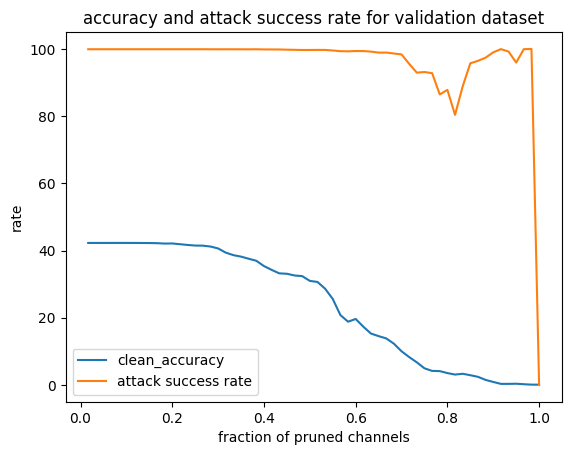

In [16]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [17]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])


The attack success rate when the accuracy drops at least 30%:  99.9047371611674


In [18]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

In [29]:
test_data_filename = '/content/drive/MyDrive/lab4/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/lab4/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [30]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [31]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [32]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [33]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

In [34]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 4s 10ms/step
2% drops model, the clean test data Classification accuracy: 42.361652377240844
401/401 [==============================] - 4s 10ms/step
2% drops model, Attack Success Rate: 99.92985190958692
401/401 [==============================] - 4s 10ms/step
4% drops model, the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 4s 10ms/step
4% drops model, Attack Success Rate: 99.92985190958692
401/401 [==============================] - 4s 10ms/step
10% drops model, the clean test data classification accuracy: 42.361652377240844
401/401 [==============================] - 4s 11ms/step
10% drops model, Attack Success Rate: 99.92985190958692


In [35]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,42.361652,99.929852
repaired_4%,42.361652,99.929852
repaired_10%,42.361652,99.929852


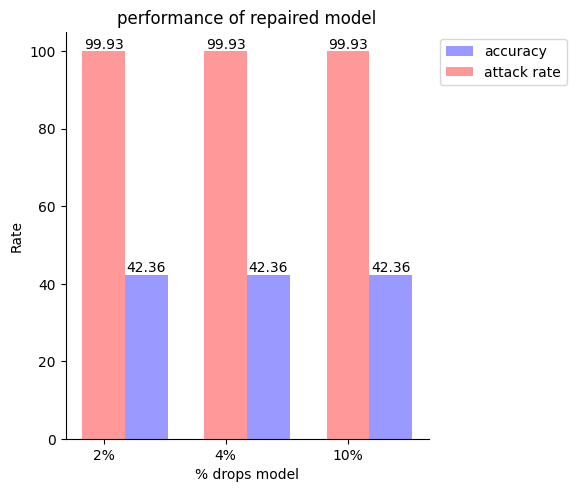

In [36]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

In [37]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)


Combined 2% drops model, the clean test data Classification accuracy: 42.361652377240844
Combined 2% drops model, Attack Success Rate: 99.92985190958692
Combined 4% drops model, the clean test data Classification accuracy: 42.361652377240844
Combined 4% drops model, Attack Success Rate: 99.92985190958692
Combined 10% drops model, the clean test data Classification accuracy: 42.361652377240844
Combined 10% drops model, Attack Success Rate: 99.92985190958692


In [39]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')


,G_text_acc,G_attack_rate
G_model,,
G_2%,42.361652,99.929852
G_4%,42.361652,99.929852
G_10%,42.361652,99.929852


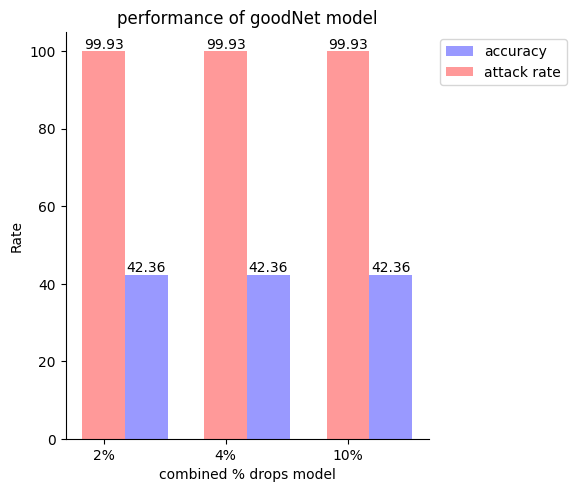

In [40]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()